In [1]:
import os
import sys
# Add the src directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
from src.data_handling.historical_data_handler import SingleSymbolDataHandler
from src.feature_engineering.feature_extractor import SingleSymbolFeatureExtractor
%cd $project_root

/Users/zhaoyub/Documents/Tradings/tradebotv3


/Users/zhaoyub/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%load_ext autoreload

## Picking up the related features

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.8f' % x)
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import datetime
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
datahandler = SingleSymbolDataHandler('BTCUSDT')
inter, begin, end = '15m', '2023-01-01', '2024-09-24'
datahandler.load_data(inter, begin, end)
BTC_indicator = SingleSymbolFeatureExtractor('BTCUSDT', datahandler)
BTC_indicator.load_full_range()
indicators = BTC_indicator.indicators[['rsi', 'macd', 'stoch_k', 'bollinger_upper', 'atr', 'obv', 'vwap', 'adx']]
datahandler.cleaned_data['close'] = datahandler.cleaned_data['close']
indicators = pd.concat([indicators,datahandler.cleaned_data[['close', 'volume']]],axis= 1)

In [5]:
BTC_indicator.indicators.columns

Index(['rsi', 'macd', 'macd_signal', 'macd_diff', 'stoch_k', 'stoch_d',
       'bollinger_mavg', 'bollinger_upper', 'bollinger_lower', 'atr', 'vwap',
       'obv', 'sma', 'ema', 'adx'],
      dtype='object')

In [6]:
# swing trading strategy
window_roll_var = 20
window_RSI = 35
window_price = 15 
# indicators['rsi_var'] = indicators['rsi'].rolling(window_roll_var).std().shift(1).bfill().ffill()
indicators['rsi_var_past'] = indicators['rsi'].rolling(window_roll_var).std().bfill().ffill()
indicators['price_var'] = indicators['close'].rolling(window_price).std().bfill().ffill()
indicators['return'] = indicators['close'].pct_change().shift(-1).bfill().ffill()
# indicators['return_var'] = indicators['return'].rolling(10).std().bfill().ffill()
# indicators['rsi_var_2'] = indicators['rsi'].rolling(window_roll_var).std().shift(-0).bfill().ffill()
indicators['rsi_min'] = indicators['rsi'].rolling(window_RSI).min().shift(1).bfill().ffill()
indicators['rsi_min_past'] = indicators['rsi'].rolling(window_RSI).min().bfill().ffill()

indicators['rsi_max'] = indicators['rsi'].rolling(window_RSI).max().shift(1).bfill().ffill()
indicators['rsi_max_past'] = indicators['rsi'].rolling(window_RSI).max().bfill().ffill()

In [7]:
indicators.head(10)

,rsi,macd,stoch_k,bollinger_upper,atr,obv,vwap,adx,close,volume,rsi_var_past,price_var,return,rsi_min,rsi_min_past,rsi_max,rsi_max_past
open_time,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00+00:00,63.45790385,9.89146828,41.84507591,16556.13719844,0.00000000,1172.53835000,16536.25596090,0.00000000,16520.69000000,1172.53835000,14.72082025,11.12408147,0.00142246,26.04033948,26.04033948,79.74046517,79.74046517
2023-01-01 00:15:00+00:00,63.45790385,9.89146828,41.84507591,16556.13719844,0.00000000,2275.16723000,16536.25596090,0.00000000,16544.19000000,1102.62888000,14.72082025,11.12408147,-0.00173837,26.04033948,26.04033948,79.74046517,79.74046517
2023-01-01 00:30:00+00:00,63.45790385,9.89146828,41.84507591,16556.13719844,0.00000000,909.51090000,16536.25596090,0.00000000,16515.43000000,1365.65633000,14.72082025,11.12408147,0.00086222,26.04033948,26.04033948,79.74046517,79.74046517
2023-01-01 00:45:00+00:00,63.45790385,9.89146828,41.84507591,16556.13719844,0.00000000,1633.52304000,16536.25596090,0.00000000,16529.67000000,724.01214000,14.72082025,11.12408147,0.00051665,26.04033948,26.04033948,79.74046517,79.74046517
2023-01-01 01:00:00+00:00,63.45790385,9.89146828,41.84507591,16556.13719844,0.00000000,2610.76984000,16536.25596090,0.00000000,16538.21000000,977.24680000,14.72082025,11.12408147,-0.00021828,26.04033948,26.04033948,79.74046517,79.74046517
2023-01-01 01:15:00+00:00,58.24036266,9.89146828,41.84507591,16556.13719844,0.00000000,1949.08463000,16536.25596090,0.00000000,16534.60000000,661.68521000,14.72082025,11.12408147,0.00032296,26.04033948,26.04033948,79.74046517,79.74046517
2023-01-01 01:30:00+00:00,63.75120301,9.89146828,41.84507591,16556.13719844,0.00000000,2741.77648000,16536.25596090,0.00000000,16539.94000000,792.69185000,14.72082025,11.12408147,0.00069710,26.04033948,26.04033948,79.74046517,79.74046517
2023-01-01 01:45:00+00:00,73.27122950,9.89146828,41.84507591,16556.13719844,0.00000000,3900.21931000,16536.25596090,0.00000000,16551.47000000,1158.44283000,14.72082025,11.12408147,-0.00014742,26.04033948,26.04033948,79.74046517,79.74046517
2023-01-01 02:00:00+00:00,68.51153797,9.89146828,41.84507591,16556.13719844,0.00000000,2997.12278000,16536.25596090,0.00000000,16549.03000000,903.09653000,14.72082025,11.12408147,0.00023325,26.04033948,26.04033948,79.74046517,79.74046517


## Data exploring

In [8]:
def calculate_stat_summary(series):
    return {
        'mean': series.mean(),
        'std': series.std(),
        'min': series.min(),
        'max': series.max(),
        'median': series.median(),
        'skew': series.skew(),
        'kurtosis': series.kurtosis(),
        'q25': series.quantile(0.25),
        'q75': series.quantile(0.75),
        'iqr': series.quantile(0.75) - series.quantile(0.25),
        'q99': series.quantile(0.99),
        'q90': series.quantile(0.90)
    }
def plot_hist(df, col, n_bins):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=n_bins, kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()
def plot_boxplot(df, col):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, data=df)
    plt.title(f'Boxplot of {col}')
    plt.show()
def plot_time_series(df, col):
    df[col].plot(figsize=(10, 5))
    plt.show()
def plot_time_series_multi(df, cols, method="minmax"):
    df_rescaled = df.copy()

    if method == "minmax":
        scaler = MinMaxScaler()
    elif method == "standard":
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid method. Use 'minmax' or 'standard'.")

    df_rescaled[cols] = scaler.fit_transform(df[cols])

    df_rescaled[cols].plot(figsize=(10, 5))
    plt.legend(cols)
    plt.show()

def plot_corr_heatmap(df):
    corr = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title('Correlation heatmap')
    plt.show()
def plot_scatter(df, x, y):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, data=df)
    plt.title(f'Scatter plot')
    plt.show()
def to_timestamp(year, month, day, hour=0, minute=0, second=0):
    return int(datetime.datetime(year, month, day, hour, minute, second, tzinfo=datetime.timezone.utc).timestamp())
    
def get_time_num(df : pd.DataFrame):
    n_time = df.index
    if not isinstance(n_time, pd.DatetimeIndex):
        n_time = pd.to_datetime(n_time)
    if n_time.tz is None:
        n_time = n_time.tz_localize("UTC")
    else:
        n_time = n_time.tz_convert("UTC")

    n_time = n_time.map(lambda x: to_timestamp(x.year, x.month, x.day, x.hour, x.minute, x.second))
    n_time = n_time - n_time[0]
    return pd.Series(n_time)

In [9]:
indicators.duplicated().sum()
print(calculate_stat_summary(indicators['return']))
if not isinstance(indicators.index, pd.DatetimeIndex):
    indicators.index = pd.to_datetime(indicators.index)
indicators.shape

{'mean': 2.542083370076168e-05, 'std': 0.0025721862370008857, 'min': -0.08979671484247265, 'max': 0.05541515925787488, 'median': 1.2541704319968261e-05, 'skew': -0.5603122547641602, 'kurtosis': 50.79883749348259, 'q25': -0.0009858368081608337, 'q75': 0.0010459475460375955, 'iqr': 0.0020317843541984293, 'q99': 0.007278485643110567, 'q90': 0.0023632746370645208}


(60664, 17)

In [10]:
ntime = get_time_num(indicators)
print(calculate_stat_summary(ntime))
ntime.head()

{'mean': 27305392.636489514, 'std': 15762691.93852023, 'min': 0, 'max': 54604800, 'median': 27306450.0, 'skew': -0.00025865102788713643, 'kurtosis': -1.199790129409554, 'q25': 13657275.0, 'q75': 40955625.0, 'iqr': 27298350.0, 'q99': 54058833.0, 'q90': 49145130.00000001}


0       0
1     900
2    1800
3    2700
4    3600
Name: open_time, dtype: int64

{'mean': 41949.252677205586, 'std': 16974.084545671885, 'min': 16510.68, 'max': 73607.8, 'median': 36470.75, 'skew': 0.3939733310291344, 'kurtosis': -1.4263041640425524, 'q25': 27176.145, 'q75': 60461.9525, 'iqr': 33285.807499999995, 'q99': 71041.3574, 'q90': 66817.637}


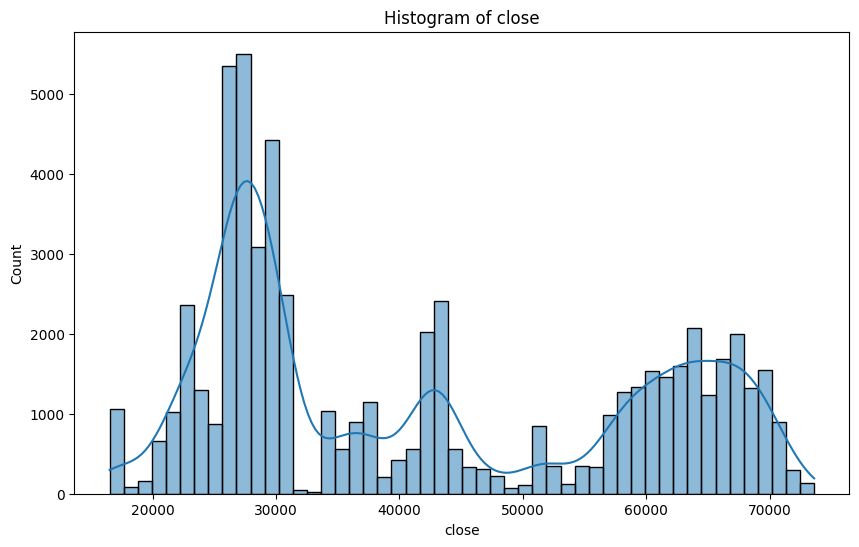

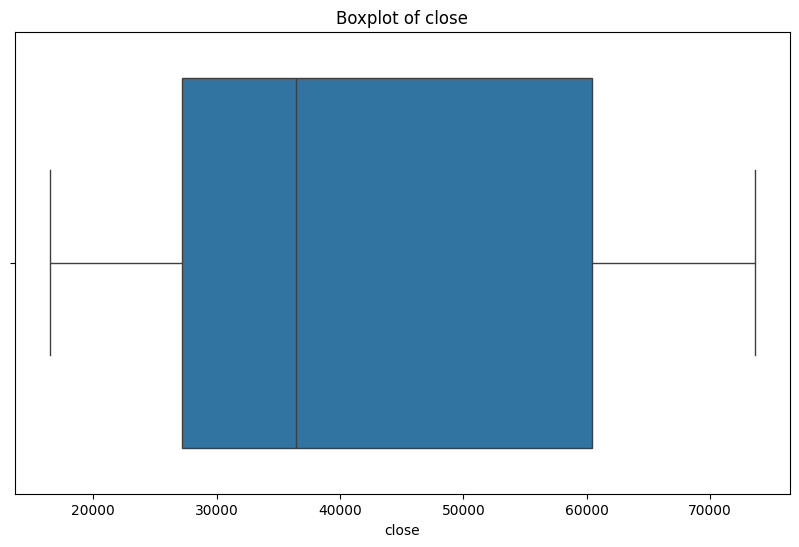

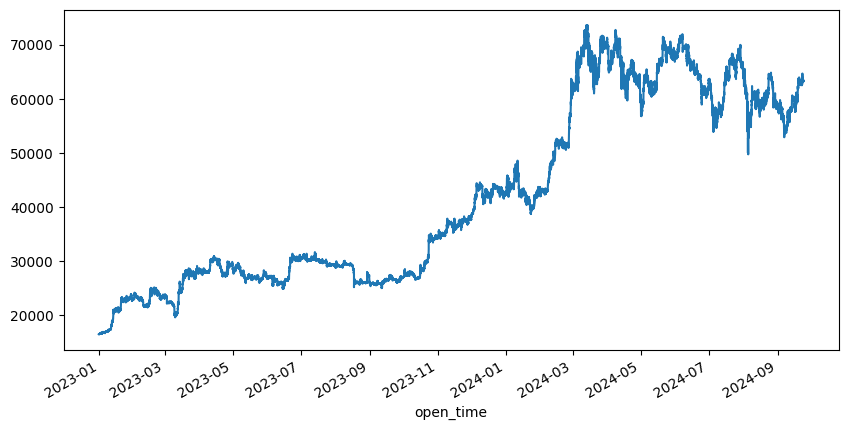

In [11]:
print(calculate_stat_summary(indicators['close']))
plot_hist(indicators, 'close', 50)
plot_boxplot(indicators, 'close')
plot_time_series(indicators, 'close')

{'mean': 14.760333188245387, 'std': 3.337168031359432, 'min': 6.024264495738843, 'max': 32.126933616061756, 'median': 14.372440644256638, 'skew': 0.6485675747458497, 'kurtosis': 0.5612379878425298, 'q25': 12.342584672393688, 'q75': 16.804436441763528, 'iqr': 4.46185176936984, 'q99': 24.018273990299832, 'q90': 19.241008832615154}


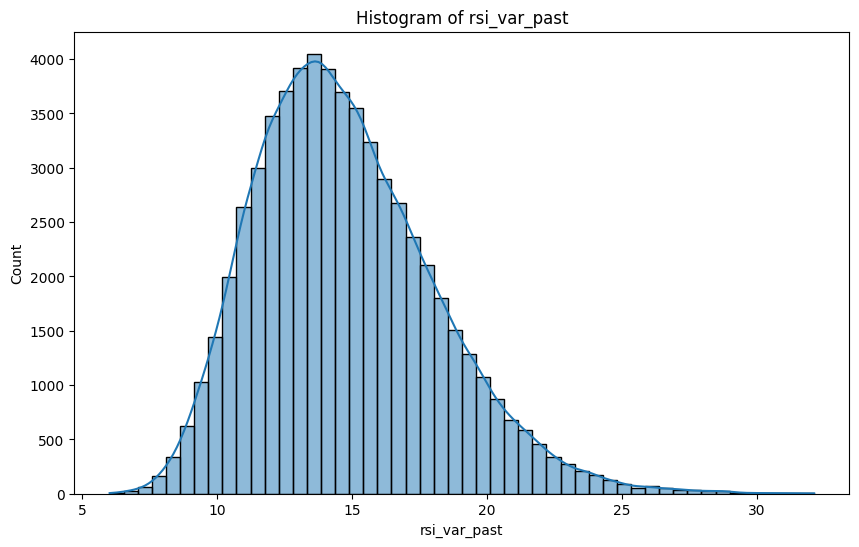

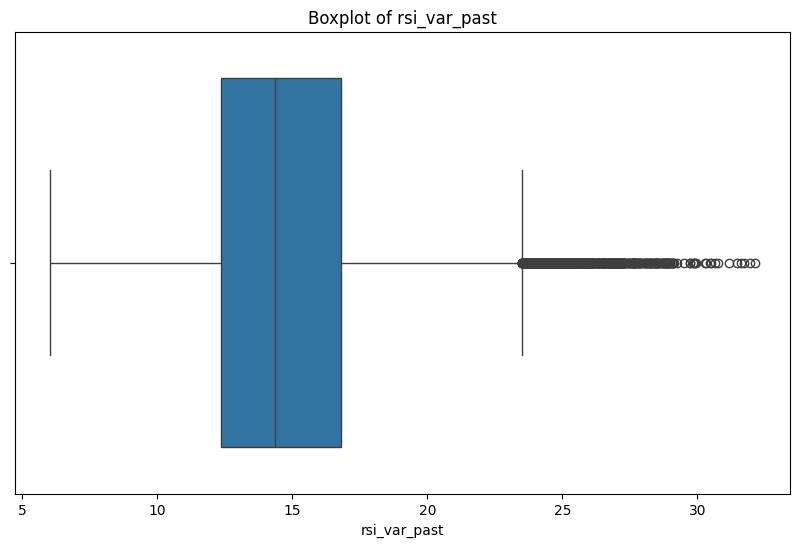

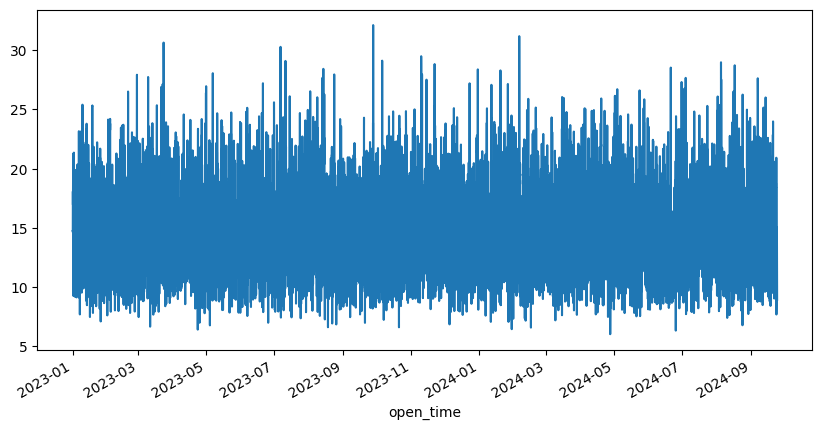

In [13]:
print(calculate_stat_summary(indicators['rsi_var_past']))
plot_hist(indicators, 'rsi_var_past', 50)
plot_boxplot(indicators, 'rsi_var_past')
plot_time_series(indicators, 'rsi_var_past')

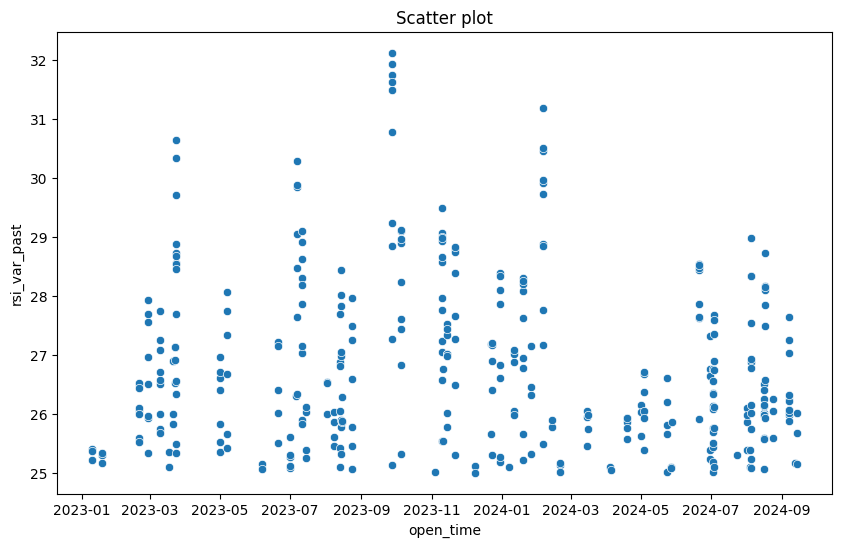

In [14]:
# get the outliers
outliers = indicators[indicators['rsi_var_past'] > 25]
plot_scatter(outliers, outliers.index,'rsi_var_past')


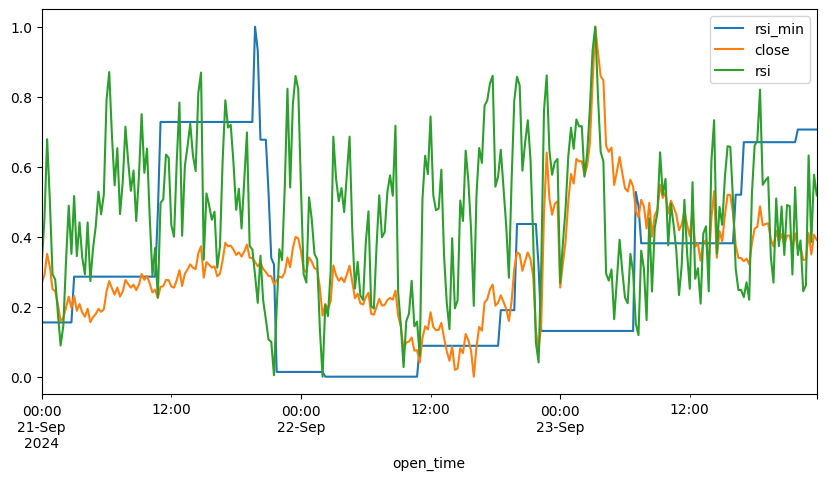

In [15]:
start_d = '2024-09-21'
end_d = '2024-09-23'
rescaled_indicators = indicators.loc[start_d: end_d].copy()
scaler = MinMaxScaler()
rescaled_indicators['close'] = scaler.fit_transform(indicators.loc[start_d: end_d]['close'].values.reshape(-1, 1))
rescaled_indicators['rsi_max'] = scaler.fit_transform(indicators.loc[start_d: end_d]['rsi_max'].values.reshape(-1, 1))
rescaled_indicators['rsi_min'] = scaler.fit_transform(indicators.loc[start_d: end_d]['rsi_min'].values.reshape(-1, 1))
rescaled_indicators['rsi'] = scaler.fit_transform(indicators.loc[start_d: end_d]['rsi'].values.reshape(-1, 1))

rescaled_indicators.plot(y=['rsi_min', 'close', 'rsi'], figsize=(10, 5))
plt.show()

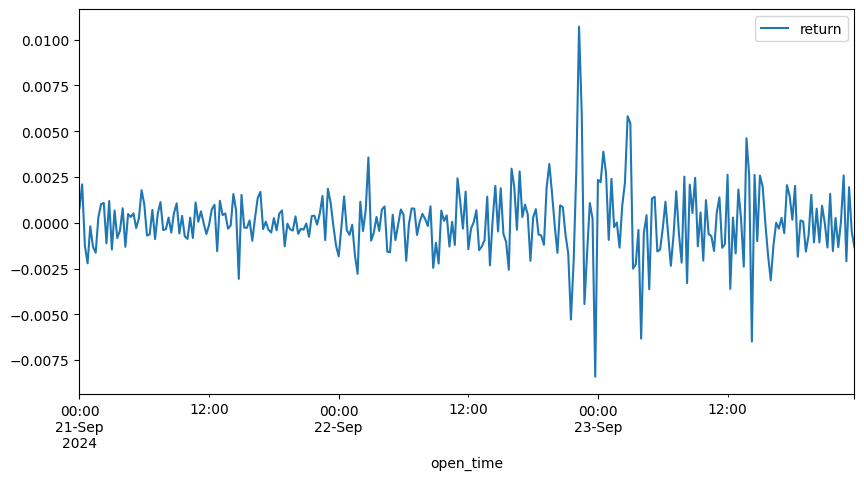

In [16]:
indicators.loc[start_d: end_d].plot(y=['return'], figsize=(10, 5))
plt.show()

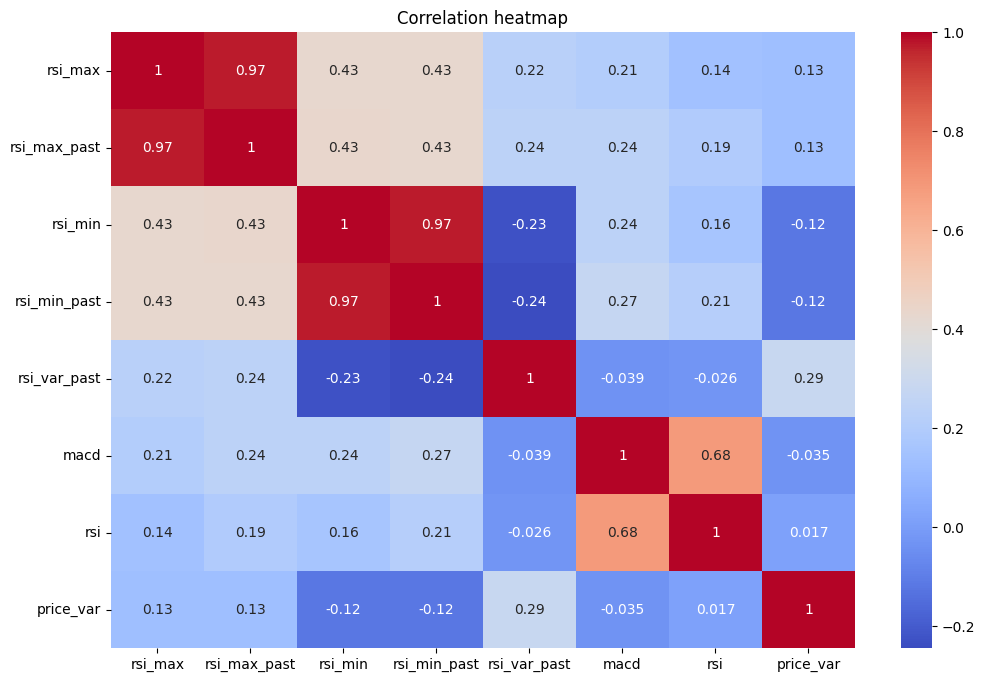

Index(['rsi_max', 'rsi_max_past', 'rsi_min', 'rsi_min_past', 'rsi_var_past',
       'macd', 'rsi', 'price_var'],
      dtype='object')

In [17]:
# select the top features that affects the rsi_var
selections = ['rsi_max', 'rsi_max_past', 'rsi_min', 'rsi_min_past', 'rsi_var_past',
       'macd', 'rsi', 'price_var']
indicators_for_rsi = indicators[selections]
indicators_for_rsi = indicators_for_rsi.copy()
# indicators_for_rsi['hour'] = indicators.index.hour
# indicators_for_rsi.loc[:,'day'] = indicators.index.day # day not useful

indicators_for_rsi = indicators_for_rsi.iloc[100:] # drop the first 100 rows due to the boundary effect
plot_corr_heatmap(indicators_for_rsi)
indicators_for_rsi.shape
indicators_for_rsi.columns

### Explanation
- Except the 'close' column, all the columns other than rsi_var is used to decide RSI range
- 'close' column can be used to create a loss function
- (frome the heatmap we already picked the high correlation columns)

## This is a time series data
- use chronological split

---------------Approach One----------------
- two-step forecasting strategy
- from indicators to rsi_var
- from rsi_var to RSI limit classes

### First try for the first model --- Random Forest
- no need to standarize the data

In [20]:
"""
X = indicators_for_rsi.drop(columns=['rsi_var_past', 'close'])
y = indicators_for_rsi['rsi_var']
X.shape, y.shape
"""

"\nX = indicators_for_rsi.drop(columns=['rsi_var_past', 'close'])\ny = indicators_for_rsi['rsi_var']\nX.shape, y.shape\n"

In [21]:
"""
# split_idx = int(0.8 * len(X))
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    print(X_train.index[-1], X_test.index[-1])
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'MSE: {mse}, MAE: {mae}, R2: {r2}')
    print(f"Fold {fold+1} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}\n")
"""


'\n# split_idx = int(0.8 * len(X))\nfrom sklearn.model_selection import TimeSeriesSplit, GridSearchCV\ntscv = TimeSeriesSplit(n_splits=5)\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\n\nfor fold, (train_index, test_index) in enumerate(tscv.split(X)):\n    X_train, X_test = X.iloc[train_index], X.iloc[test_index]\n    y_train, y_test = y.iloc[train_index], y.iloc[test_index]\n    model = RandomForestRegressor()\n    model.fit(X_train, y_train)\n    print(X_train.index[-1], X_test.index[-1])\n    y_pred = model.predict(X_test)\n    mse = mean_squared_error(y_test, y_pred)\n    mae = mean_absolute_error(y_test, y_pred)\n    r2 = r2_score(y_test, y_pred)\n    \n    print(f\'MSE: {mse}, MAE: {mae}, R2: {r2}\')\n    print(f"Fold {fold+1} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}\n")\n'

## Comment on the current model:
- MSE and MAE:
    The absolute error metrics vary across folds, with MSE values roughly between 2.37 and 3.59, and MAE values between 1.18 and 1.40. These values indicate that, on average, the model's predictions deviate by about 1.2–1.4 units from the actual values. 

    Consider the RSI-variance is smaller than 1, this is worrisome.
- R^2:
    This means your model explains about 50% of the variability in the target
- During time 2023-11-13 to 2024-06-10: when there is a big trend, the model is less convincing.


### Hyperparameter tuning

In [22]:
"""
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [25, 30, 35],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [15, 20, 25]
}
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=tscv,
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1)
grid_search.fit(X, y)
mse = -grid_search.best_score_
print(f'Best MSE: {mse}')
r2 = grid_search.best_estimator_.score(X, y)
print(f'Best R2: {r2}')
"""

"\nfrom sklearn.model_selection import TimeSeriesSplit, GridSearchCV\nparam_grid = {\n    'n_estimators': [50, 100, 150],\n    'max_depth': [25, 30, 35],\n    'min_samples_split': [2, 4],\n    'min_samples_leaf': [15, 20, 25]\n}\nrf = RandomForestRegressor(random_state=42)\ngrid_search = GridSearchCV(estimator=rf, \n                           param_grid=param_grid, \n                           cv=tscv,\n                           scoring='neg_mean_squared_error', \n                           n_jobs=-1)\ngrid_search.fit(X, y)\nmse = -grid_search.best_score_\nprint(f'Best MSE: {mse}')\nr2 = grid_search.best_estimator_.score(X, y)\nprint(f'Best R2: {r2}')\n"

In [23]:
# grid_search.best_params_

- An R² of 0.78 indicates that the model explains about 78% of the variance, which seems promising on a relative scale. 
- However, because the target variable (RSI variance) is typically around 0.5 and the MSE is 2.72, this means that in absolute terms, your predictions are off by a significant margin compared to the small scale of the target.

In [58]:
X_max = indicators_for_rsi[['rsi_var_past',
       'macd', 'rsi', 'price_var', 'rsi_min_past', 'rsi_max_past']]
y_max = indicators_for_rsi['rsi_max']
X_max.shape, y_max.shape

((60564, 6), (60564,))

In [59]:
 # split_idx = int(0.8 * len(X))
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for fold, (train_index, test_index) in enumerate(tscv.split(X_max)):
    X_train, X_test = X_max.iloc[train_index], X_max.iloc[test_index]
    y_train, y_test = y_max.iloc[train_index], y_max.iloc[test_index]
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    print(X_train.index[-1], X_test.index[-1])
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'MSE: {mse}, MAE: {mae}, R2: {r2}')
    print(f"Fold {fold+1} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}\n")

    


2023-04-17 06:30:00+00:00 2023-07-31 10:00:00+00:00
MSE: 6.137028048346138, MAE: 1.1772462282607234, R2: 0.9213496435782617
Fold 1 - MSE: 6.1370, MAE: 1.1772, R2: 0.9213

2023-07-31 10:00:00+00:00 2023-11-13 13:30:00+00:00
MSE: 4.958859496755083, MAE: 1.04351361678599, R2: 0.9338614221215524
Fold 2 - MSE: 4.9589, MAE: 1.0435, R2: 0.9339

2023-11-13 13:30:00+00:00 2024-02-26 17:00:00+00:00
MSE: 5.280395340103542, MAE: 1.134115821325779, R2: 0.929061466889949
Fold 3 - MSE: 5.2804, MAE: 1.1341, R2: 0.9291

2024-02-26 17:00:00+00:00 2024-06-10 20:30:00+00:00
MSE: 5.921234945798749, MAE: 1.2921029250937324, R2: 0.9213684117206673
Fold 4 - MSE: 5.9212, MAE: 1.2921, R2: 0.9214

2024-06-10 20:30:00+00:00 2024-09-24 00:00:00+00:00
MSE: 5.049598417747141, MAE: 1.12776157835474, R2: 0.9352474225438516
Fold 5 - MSE: 5.0496, MAE: 1.1278, R2: 0.9352



In [60]:
X_min = indicators_for_rsi[['rsi_var_past',
       'macd', 'rsi', 'price_var', 'rsi_min_past', 'rsi_max_past']]
y_min = indicators_for_rsi['rsi_min']
X_min.shape, y_min.shape
X_min.columns

Index(['rsi_var_past', 'macd', 'rsi', 'price_var', 'rsi_min_past',
       'rsi_max_past'],
      dtype='object')

In [61]:
# split_idx = int(0.8 * len(X))
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

for fold, (train_index, test_index) in enumerate(tscv.split(X_min)):
    X_train, X_test = X_min.iloc[train_index], X_min.iloc[test_index]
    y_train, y_test = y_min.iloc[train_index], y_min.iloc[test_index]
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    print(X_train.index[-1], X_test.index[-1])
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'MSE: {mse}, MAE: {mae}, R2: {r2}')
    print(f"Fold {fold+1} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}\n")

    

2023-04-17 06:30:00+00:00 2023-07-31 10:00:00+00:00
MSE: 5.979900834265959, MAE: 1.1458234685196609, R2: 0.9289483670454877
Fold 1 - MSE: 5.9799, MAE: 1.1458, R2: 0.9289

2023-07-31 10:00:00+00:00 2023-11-13 13:30:00+00:00
MSE: 5.154982485328355, MAE: 1.114106885703958, R2: 0.9247099463721894
Fold 2 - MSE: 5.1550, MAE: 1.1141, R2: 0.9247

2023-11-13 13:30:00+00:00 2024-02-26 17:00:00+00:00
MSE: 5.833818560960986, MAE: 1.2116504189903208, R2: 0.9286053792304477
Fold 3 - MSE: 5.8338, MAE: 1.2117, R2: 0.9286

2024-02-26 17:00:00+00:00 2024-06-10 20:30:00+00:00
MSE: 6.320201382842611, MAE: 1.3591192906972376, R2: 0.9263895027863107
Fold 4 - MSE: 6.3202, MAE: 1.3591, R2: 0.9264

2024-06-10 20:30:00+00:00 2024-09-24 00:00:00+00:00
MSE: 4.696538847097878, MAE: 1.0101930910485377, R2: 0.94111067443423
Fold 5 - MSE: 4.6965, MAE: 1.0102, R2: 0.9411



In [62]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
param_grid = {
    'n_estimators': [1, 5, 10],
    'max_depth': [25, 30, 35],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [15, 20, 25]
}
rf = RandomForestRegressor(random_state=42)
grid_search_max = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=tscv,
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1)
grid_search_max.fit(X_max, y_max)
mse = -grid_search_max.best_score_
print(f'Best MSE_max: {mse}')
r2 = grid_search_max.best_estimator_.score(X_max, y_max)
print(f'Best R2_max: {r2}')
grid_search_max.best_params_
model_max = grid_search_max.best_estimator_

grid_search_min = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=tscv,
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1)
grid_search_min.fit(X_min, y_min)
mse = -grid_search_min.best_score_
print(f'Best MSE_min: {mse}')
r2 = grid_search_min.best_estimator_.score(X_min, y_min)
print(f'Best R2_min: {r2}')
grid_search_min.best_params_
model_min = grid_search_min.best_estimator_



Best MSE_max: 3.3095046376539026
Best R2_max: 0.9634896277992581
Best MSE_min: 3.5289758318174207
Best R2_min: 0.9628251546914939


### The model performs much better
- Let's see how well it performs for the unseen data (new fetched)

In [ ]:
datahandler_2 = SingleSymbolDataHandler('BTCUSDT')
inter, begin_2, end_2 = '15m', '2024-09-24', '2025-03-01'
datahandler_2.load_data(inter, begin_date=begin_2, end_date=end_2)
BTC_indicator_2 = SingleSymbolFeatureExtractor('BTCUSDT', datahandler_2)
BTC_indicator_2.load_full_range()
indicators_2 = BTC_indicator_2.indicators[['rsi', 'macd', 'stoch_k', 'bollinger_upper', 'atr', 'obv', 'vwap', 'adx']]
datahandler_2.cleaned_data['close'] = datahandler_2.cleaned_data['close']
indicators_2 = pd.concat([indicators_2,datahandler_2.cleaned_data[['close', 'volume']]],axis= 1)


                                    open           high            low  \
open_time                                                                
2024-09-24 00:00:00+00:00 63339.99000000 63401.21000000 63206.20000000   
2024-09-24 00:15:00+00:00 63254.84000000 63355.77000000 63226.33000000   
2024-09-24 00:30:00+00:00 63306.00000000 63330.00000000 62800.49000000   
2024-09-24 00:45:00+00:00 63249.99000000 63249.99000000 62899.90000000   
2024-09-24 01:00:00+00:00 62906.01000000 63096.00000000 62850.00000000   

                                   close       volume  
open_time                                              
2024-09-24 00:00:00+00:00 63254.84000000 210.45560000  
2024-09-24 00:15:00+00:00 63306.00000000 106.27126000  
2024-09-24 00:30:00+00:00 63249.99000000 730.60474000  
2024-09-24 00:45:00+00:00 62906.00000000 454.61290000  
2024-09-24 01:00:00+00:00 63035.99000000 173.12294000  


In [132]:
indicators_2['rsi_var_past'] = indicators_2['rsi'].rolling(window_roll_var).std().bfill().ffill()
indicators_2['price_var'] = indicators_2['close'].rolling(window_price).std().bfill().ffill()
indicators_2['return'] = indicators_2['close'].pct_change().shift(-1).bfill().ffill()
# indicators['return_var'] = indicators['return'].rolling(10).std().bfill().ffill()
# indicators['rsi_var_2'] = indicators['rsi'].rolling(window_roll_var).std().shift(-0).bfill().ffill()
indicators_2['rsi_min'] = indicators_2['rsi'].rolling(window_RSI).min().shift(1).bfill().ffill()
indicators_2['rsi_min_past'] = indicators_2['rsi'].rolling(window_RSI).min().bfill().ffill()

indicators_2['rsi_max'] = indicators_2['rsi'].rolling(window_RSI).max().shift(1).bfill().ffill()
indicators_2['rsi_max_past'] = indicators_2['rsi'].rolling(window_RSI).max().bfill().ffill()

In [133]:
indicators_2.columns

Index(['rsi', 'macd', 'stoch_k', 'bollinger_upper', 'atr', 'obv', 'vwap',
       'adx', 'close', 'volume', 'rsi_var_past', 'price_var', 'return',
       'rsi_min', 'rsi_min_past', 'rsi_max', 'rsi_max_past'],
      dtype='object')

In [134]:
X_max_2 = indicators_2[['rsi_var_past',
       'macd', 'rsi', 'price_var', 'rsi_min_past', 'rsi_max_past']]
y_max_2 = indicators_2['rsi_max']
X_max_2.shape, y_max_2.shape
X_min_2 = indicators_2[['rsi_var_past',
       'macd', 'rsi', 'price_var', 'rsi_min_past', 'rsi_max_past']]
y_min_2 = indicators_2['rsi_min']
X_min_2.shape, y_min_2.shape
# X_max_2.head()

((15169, 6), (15169,))

In [135]:
mse_max = mean_squared_error(y_max_2, model_max.predict(X_max_2))
r2_max = r2_score(y_max_2, model_max.predict(X_max_2))
print(f'MSE_max: {mse_max}, R2_max: {r2_max}')
mse_min = mean_squared_error(y_min_2, model_min.predict(X_min_2))
r2_min = r2_score(y_min_2, model_min.predict(X_min_2))
print(f'MSE_min: {mse_min}, R2_min: {r2_min}')

MSE_max: 3.4185105741196193, R2_max: 0.952769616293357
MSE_min: 3.6073620785928933, R2_min: 0.9556874538318083


## Now we try the model to generate buy and sell signals
- On the unseen data 

In [136]:
indicators_2.shape, model_max.predict(X_max_2).shape

((15169, 17), (15169,))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def dynamic_rsi_trading_with_capital(indicators, rsi_max_pred, rsi_min_pred, fee=0.001, initial_capital=1000, mae=2):
    """
    Simulates a dynamic RSI trading strategy using full capital investment and records capital evolution over time.
    
    Parameters:
        indicators (pd.DataFrame): DataFrame with at least 'rsi' and 'close' columns.
        rsi_max_pred (array-like): Predicted RSI upper limits (one per row).
        rsi_min_pred (array-like): Predicted RSI lower limits (one per row).
        fee (float): Transaction fee as a fraction (default: 0.001 for 0.1% fee).
        initial_capital (float): Starting capital.
        mae (float): Margin adjustment error to modify the RSI threshold.
    
    Returns:
        trades (list): List of executed trades (each a dict with details).
        capital_series (pd.Series): Capital value recorded at each time step (using indicators' index).
    """
    if len(rsi_max_pred) != len(indicators) or len(rsi_min_pred) != len(indicators):
        raise ValueError("Prediction arrays must have the same length as the indicators DataFrame.")
    
    in_position = False   # True if holding the asset
    capital = initial_capital
    position_size = 0     # Number of asset units purchased
    entry_capital = 0     # Capital allocated at entry
    trades = []         # List to record each trade
    capital_record = [] # Record capital evolution
    
    for i in range(len(indicators)):
        current_rsi = indicators['rsi'].iloc[i]
        current_price = indicators['close'].iloc[i]
        predicted_rsi_max = rsi_max_pred[i]
        predicted_rsi_min = rsi_min_pred[i]
        
        # Buy signal: not in position and current RSI is low (with margin adjustment)
        if not in_position and current_rsi <= predicted_rsi_min + mae:
            # Buy using full capital; fee applied increases the buying price
            buy_price = current_price * (1 + fee)
            position_size = capital / buy_price  
            entry_capital = capital
            in_position = True
            trades.append({
                'type': 'buy',
                'price': buy_price,
                'index': indicators.index[i]
            })
        
        # Sell signal: in position and current RSI is high (with margin adjustment)
        elif in_position and current_rsi >= predicted_rsi_max - mae:
            # Sell using full position; fee applied decreases the selling price
            sell_price = current_price * (1 - fee)
            new_capital = position_size * sell_price  # New capital after selling
            profit = new_capital - entry_capital
            capital = new_capital
            in_position = False
            trades.append({
                'type': 'sell',
                'price': sell_price,
                'index': indicators.index[i],
                'profit': profit
            })
        
        capital_record.append(capital)
    
    # If still in position at the end, close the position at the final price.
    if in_position:
        final_price = indicators['close'].iloc[-1] * (1 - fee)
        new_capital = position_size * final_price
        profit = new_capital - entry_capital
        capital = new_capital
        trades.append({
            'type': 'sell',
            'price': final_price,
            'index': indicators.index[-1],
            'profit': profit
        })
        capital_record[-1] = capital  # Update the final capital record
    
    # Create a pandas Series for capital evolution using the same index as the indicators.
    capital_series = pd.Series(capital_record, index=indicators.index)
    
    return trades, capital_series

def compute_performance_metrics(trades, capital_series, indicators, initial_capital=1000):
    """
    Computes performance metrics based on the executed trades and capital evolution.
    
    Metrics include:
      - Total ROI (%)
      - Max Drawdown (%)
      - Sharpe Ratio (using period returns from the capital series)
      - Symbol ROI (%) based on the close price changes
      - Trade Efficiency (%)
      - Trade Distribution (winning and losing trades and win rate)
      - Profit Attribution (total, average, max, and min profit)
    
    Parameters:
        trades (list): List of trade dictionaries.
        capital_series (pd.Series): Series of capital values over time.
        indicators (pd.DataFrame): DataFrame that contains the 'close' price column.
        initial_capital (float): Starting capital.
    
    Returns:
        dict: Dictionary with performance metrics.
    """
    # Total ROI (%)
    final_capital = capital_series.iloc[-1]
    total_roi = ((final_capital - initial_capital) / initial_capital) * 100

    # Max Drawdown (%)
    running_max = capital_series.cummax()
    drawdowns = (capital_series - running_max) / running_max
    max_drawdown = abs(drawdowns.min()) * 100
    
    # Compute returns from capital series (assume equal time intervals)
    returns = capital_series.pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std() if returns.std() != 0 else np.nan

    # Symbol ROI (%) based on the underlying asset's price
    initial_price = indicators['close'].iloc[0]
    final_price = indicators['close'].iloc[-1]
    symbol_roi = ((final_price - initial_price) / initial_price) * 100

    # Trade Efficiency (%) = (net profit / total absolute profit) * 100
    trade_profits = [t['profit'] for t in trades if t.get('type') == 'sell' and 'profit' in t]
    total_profit = sum(trade_profits)
    gross_profit = sum(abs(p) for p in trade_profits) if trade_profits else 0
    trade_efficiency = (total_profit / gross_profit * 100) if gross_profit != 0 else np.nan

    # Trade Distribution: count winning, losing trades and win rate.
    winning_trades = [p for p in trade_profits if p > 0]
    losing_trades = [p for p in trade_profits if p < 0]
    win_rate = (len(winning_trades) / len(trade_profits) * 100) if trade_profits else np.nan
    trade_distribution = {
        'winning_trades': len(winning_trades),
        'losing_trades': len(losing_trades),
        'win_rate (%)': win_rate
    }
    
    # Profit Attribution: total, average, maximum, and minimum profit per trade.
    profit_attribution = {
        'total_profit': total_profit,
        'average_profit': (total_profit / len(trade_profits)) if trade_profits else 0,
        'max_profit': max(trade_profits) if trade_profits else 0,
        'min_profit': min(trade_profits) if trade_profits else 0
    }
    
    return {
        'Total ROI (%)': total_roi,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Symbol ROI (%)': symbol_roi,
        'Trade Efficiency (%)': trade_efficiency,
        'Trade Distribution': trade_distribution,
        'Profit Attribution': profit_attribution,
    }

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def plot_price_and_capital(indicators, capital_series):
    """
    Plots both the asset's price (from indicators['close']) and the capital evolution on the same figure.
    
    Parameters:
        indicators (pd.DataFrame): DataFrame containing at least the 'close' column for asset prices.
        capital_series (pd.Series): Series representing the evolution of capital over time.
    """
    # Ensure the capital_series index is timezone naive and normalized (date only)
    if isinstance(capital_series.index, pd.DatetimeIndex):
        if capital_series.index.tz is not None:
            capital_series.index = capital_series.index.tz_localize(None)
    else:
        capital_series.index = pd.to_datetime(capital_series.index, errors='coerce')
    capital_series.index = capital_series.index.normalize()
    
    # Also, ensure the indicators index is timezone naive and normalized
    if isinstance(indicators.index, pd.DatetimeIndex):
        if indicators.index.tz is not None:
            indicators.index = indicators.index.tz_localize(None)
    else:
        indicators.index = pd.to_datetime(indicators.index, errors='coerce')
    indicators.index = indicators.index.normalize()
    
    # Create a figure and a primary axis for capital
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    color_capital = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Capital', color=color_capital)
    ax1.plot(capital_series.index, capital_series.values, label='Capital', color=color_capital)
    ax1.tick_params(axis='y', labelcolor=color_capital)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Create a secondary axis for the price
    ax2 = ax1.twinx()
    color_price = 'tab:red'
    ax2.set_ylabel('Price', color=color_price)
    ax2.plot(indicators.index, indicators['close'], label='Price', color=color_price)
    ax2.tick_params(axis='y', labelcolor=color_price)
    
    # Improve layout and rotate dates
    fig.autofmt_xdate()
    fig.tight_layout()
    
    plt.title('Capital and Price Evolution Over Time')
    plt.grid(True)
    plt.show()

# Example usage:
# plot_price_and_capital(indicators_2, capital_series)

def plot_capital(capital_series):
    """
    Plots the evolution of capital over time with simplified date formatting.
    
    Parameters:
        capital_series (pd.Series): Capital values with a time/index.
    """
    # Check if the index is numeric (e.g., Unix epoch seconds)
    if isinstance(capital_series.index, pd.DatetimeIndex):
        if capital_series.index.tz is not None:
            capital_series.index = capital_series.index.tz_localize(None)
    else:
        # Otherwise, attempt to convert the index to datetime.
        capital_series.index = pd.to_datetime(capital_series.index, errors='coerce')
    
    # If conversion failed (NaT values), print a warning
    if capital_series.index.isnull().any():
        print("Warning: Some index values could not be converted to datetime. Check your index format.")
    
    # Normalize the dates to remove time components
    capital_series.index = capital_series.index.normalize()
    
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    capital_series.plot(ax=ax, label='Capital', color='blue')
    
    # Format the x-axis to show only the date (Year-Month-Day)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotate date labels for clarity
    
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.title('Capital Evolution Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()




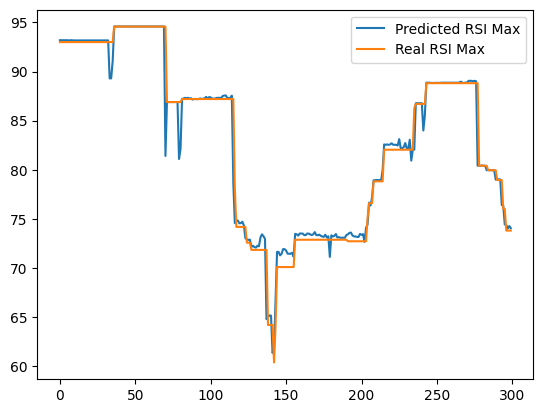

In [153]:
rsi_max_pred = model_max.predict(X_max_2)
rsi_min_pred = model_min.predict(X_min_2)
rsi_max_real = np.array(indicators_2['rsi_max'])
rsi_min_real = np.array(indicators_2['rsi_min'])
plt.plot(rsi_max_pred[0:300], label='Predicted RSI Max')
# plt.plot(rsi_min_pred, label='Predicted RSI Min')
plt.plot(rsi_max_real[0:300], label='Real RSI Max')
# plt.plot(rsi_min_real, label='Real RSI Min')
plt.legend()
plt.show()

*The real prediction of the model is meaningless... It is not much different than the rolling window max/min*

(15169,) (15169,)
Performance Metrics:
Total ROI (%): -7.715655748417465
Max Drawdown (%): 36.420806568071995
Sharpe Ratio: -0.001857081602441029
Symbol ROI (%): 33.64435037698302
Trade Efficiency (%): -3.4341469120587074
Trade Distribution: {'winning_trades': 71, 'losing_trades': 62, 'win_rate (%)': 53.383458646616546}
Profit Attribution: {'total_profit': -77.15655748417464, 'average_profit': -0.5801244923622153, 'max_profit': 95.50457105351575, 'min_profit': -73.69422166385311}


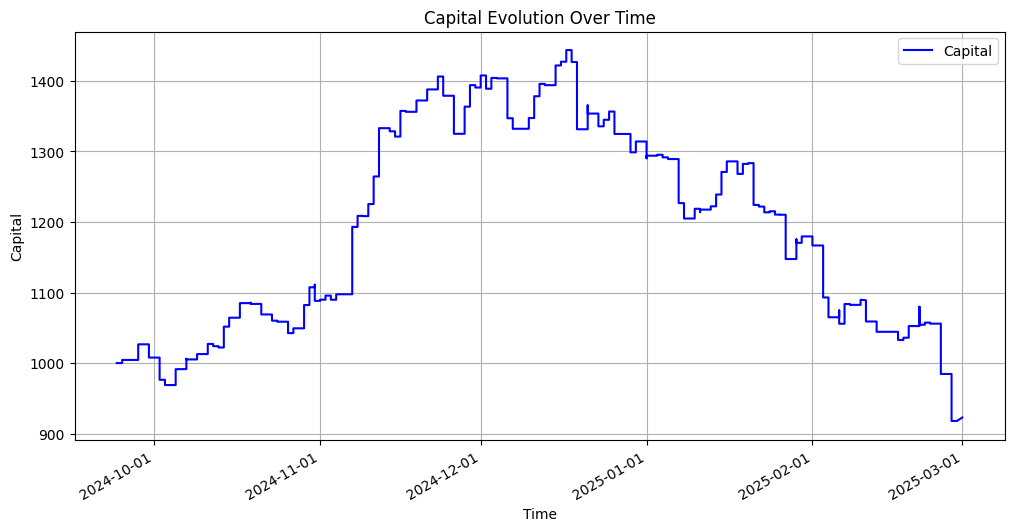

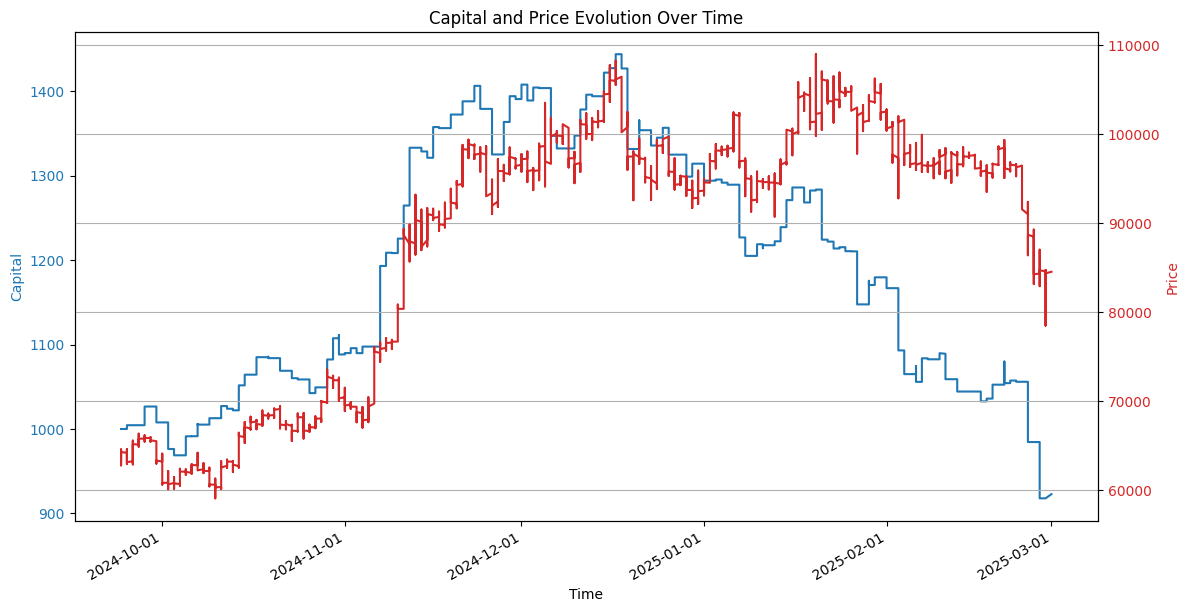

In [174]:
rsi_max_pred = model_max.predict(X_max_2)
rsi_min_pred = model_min.predict(X_min_2)
print(rsi_max_pred.shape, rsi_min_pred.shape)
trades, capital_series = dynamic_rsi_trading_with_capital(indicators_2, rsi_max_real, rsi_min_real, mae = -5)
performance = compute_performance_metrics(trades, capital_series, indicators_2)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

plot_capital(capital_series)
plot_price_and_capital(indicators_2, capital_series)


87.90298425651525 12.16498878385353
Performance Metrics:
Total ROI (%): 30.431348119418296
Max Drawdown (%): 10.54689365043808
Sharpe Ratio: 0.011360845220293377
Symbol ROI (%): 33.64435037698302
Trade Efficiency (%): 18.87260832307376
Trade Distribution: {'winning_trades': 60, 'losing_trades': 19, 'win_rate (%)': 75.9493670886076}
Profit Attribution: {'total_profit': 304.31348119418294, 'average_profit': 3.8520693822048475, 'max_profit': 44.709963722152224, 'min_profit': -140.3432104709318}


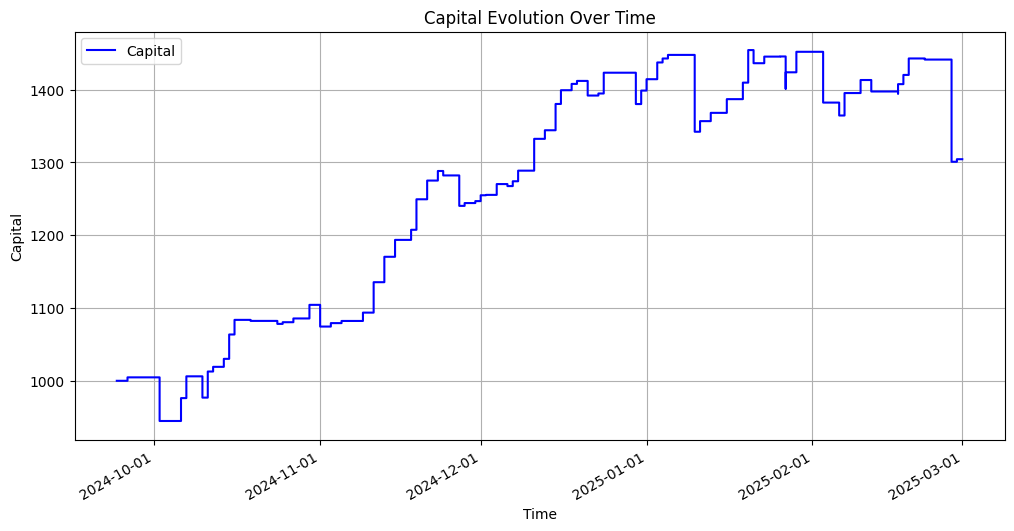

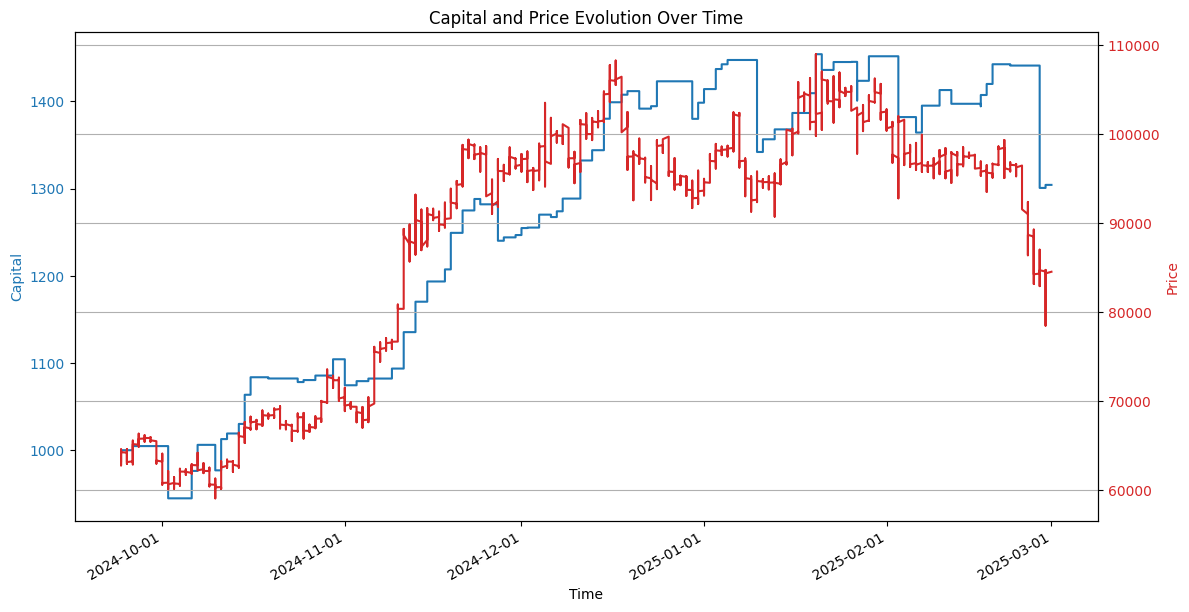

In [175]:
mae = 6
rsi_max_simple = pd.Series([np.median(indicators_2['rsi_max'])+mae] * len(indicators_2))
rsi_min_simple = pd.Series([np.median(indicators_2['rsi_min'])-mae] * len(indicators_2))
print(np.median(indicators_2['rsi_max'])+mae, np.median(indicators_2['rsi_min'])-mae)
trades, capital_series = dynamic_rsi_trading_with_capital(indicators_2, rsi_max_simple, rsi_min_simple)
performance = compute_performance_metrics(trades, capital_series, indicators_2)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

plot_capital(capital_series)
plot_price_and_capital(indicators_2, capital_series)


(60564,) (60564,) (60564, 17)
Performance Metrics:
Total ROI (%): 73.12229134505235
Max Drawdown (%): 28.653956091845423
Sharpe Ratio: 0.0060550973551103055
Symbol ROI (%): 282.882555147515
Trade Efficiency (%): 10.66350072731391
Trade Distribution: {'winning_trades': 168, 'losing_trades': 114, 'win_rate (%)': 59.57446808510638}
Profit Attribution: {'total_profit': 731.2229134505235, 'average_profit': 2.5929890547890904, 'max_profit': 201.90299487265725, 'min_profit': -171.59547469648987}


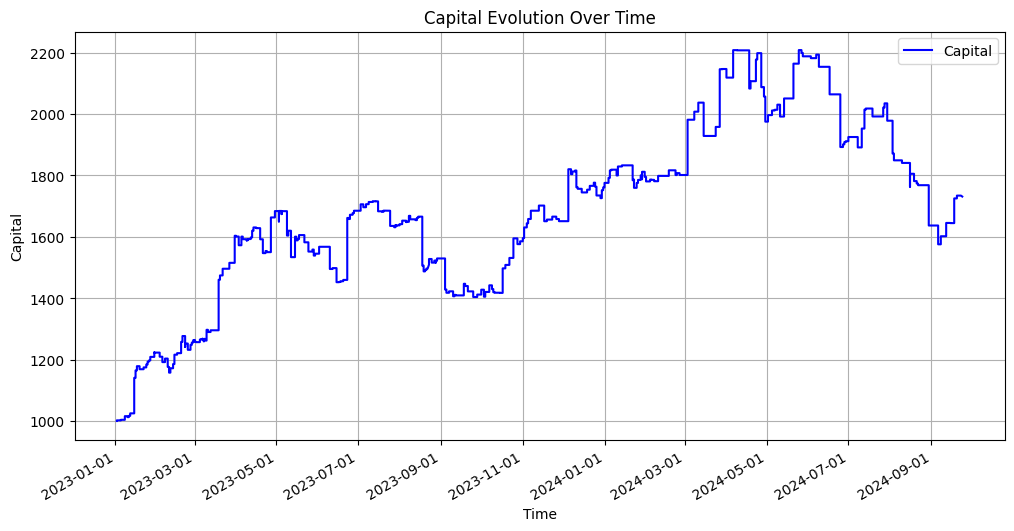

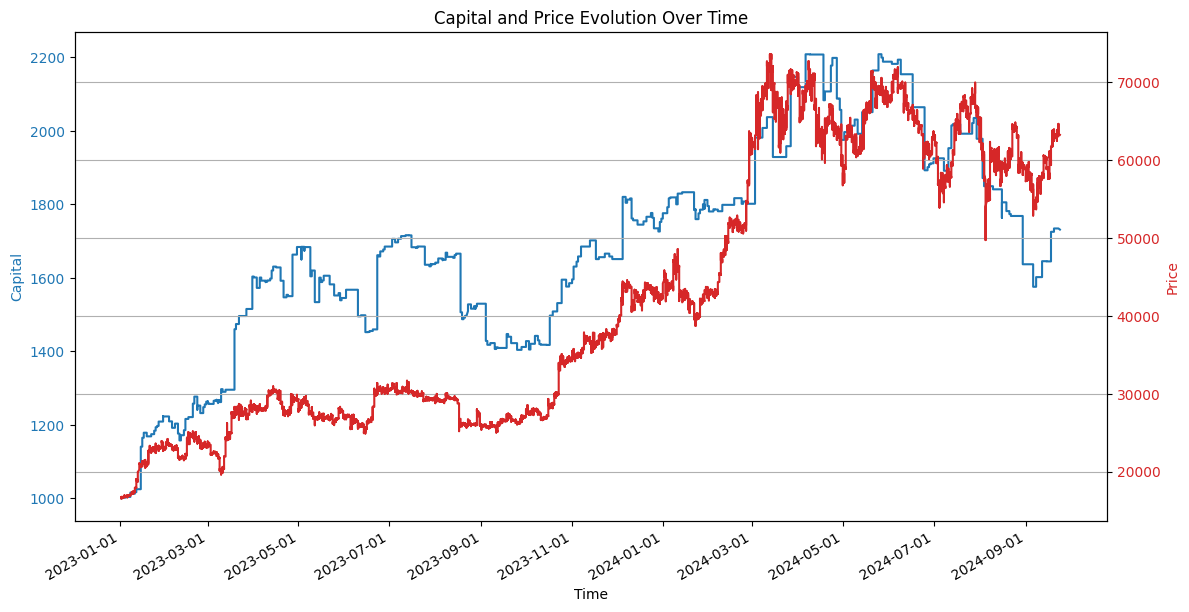

In [176]:
rsi_max_pred = model_max.predict(X_max)
rsi_min_pred = model_min.predict(X_min)
print(rsi_max_pred.shape, rsi_min_pred.shape, indicators[100:].shape)
trades, capital_series = dynamic_rsi_trading_with_capital(indicators[100:], rsi_max_pred, rsi_min_pred, mae = -5)
performance = compute_performance_metrics(trades, capital_series, indicators)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

plot_capital(capital_series)
plot_price_and_capital(indicators[100:], capital_series)

91.60206897405126 9.149878302564602
Performance Metrics:
Total ROI (%): 55.79974048282409
Max Drawdown (%): 18.475648588121615
Sharpe Ratio: 0.00608496451533547
Symbol ROI (%): 282.882555147515
Trade Efficiency (%): 15.209240023837403
Trade Distribution: {'winning_trades': 97, 'losing_trades': 41, 'win_rate (%)': 70.28985507246377}
Profit Attribution: {'total_profit': 557.9974048282409, 'average_profit': 4.043459455277108, 'max_profit': 109.6751446707317, 'min_profit': -144.9005978774535}


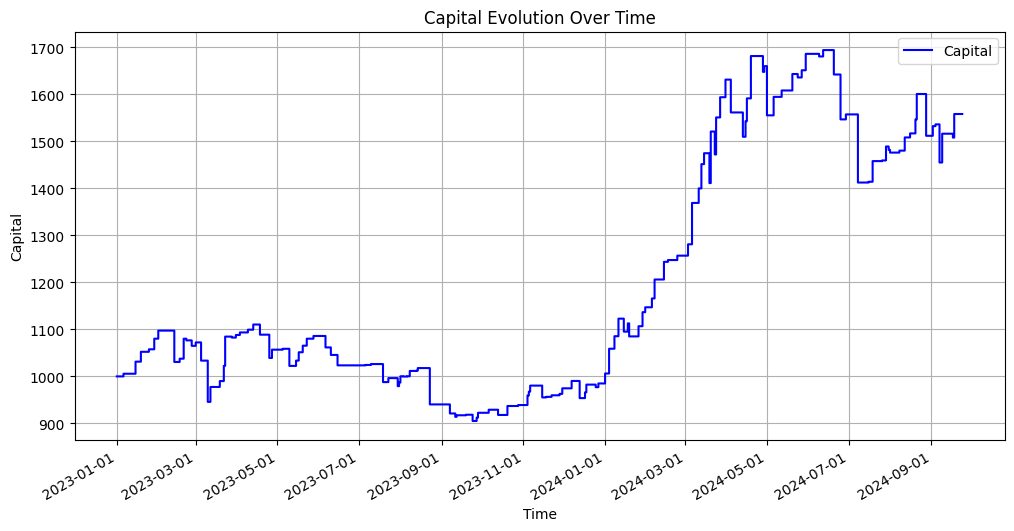

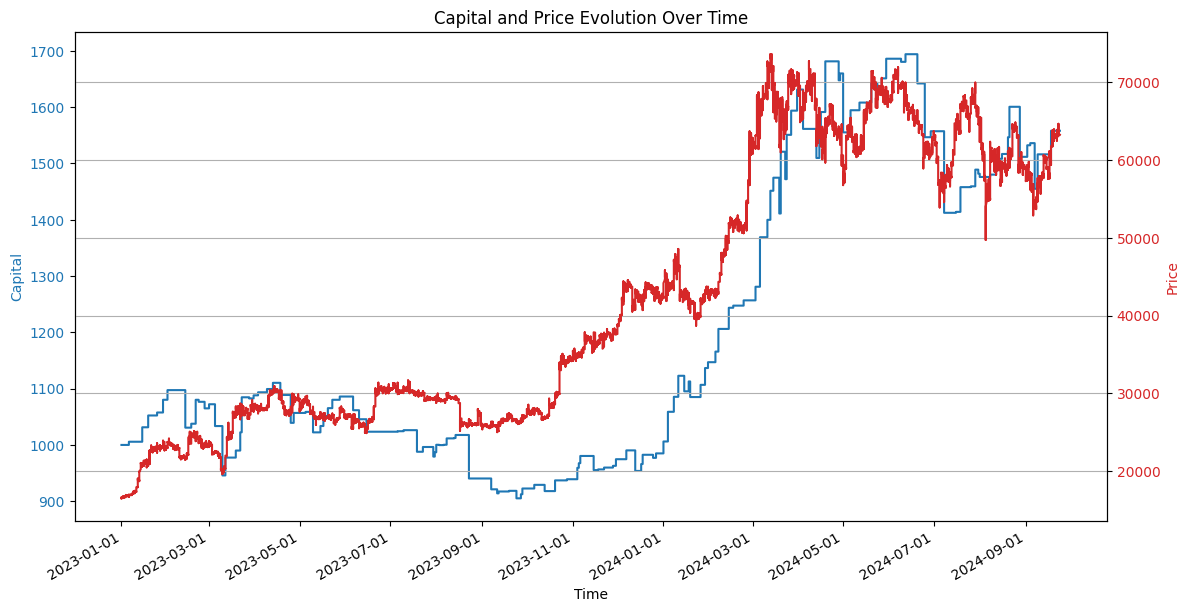

In [179]:
mae = 10
rsi_max_simple = pd.Series([np.median(indicators_2['rsi_max'])+mae] * len(indicators))
rsi_min_simple = pd.Series([np.median(indicators_2['rsi_min'])-mae] * len(indicators))
print(np.median(indicators['rsi_max'])+mae, np.median(indicators['rsi_min'])-mae)
trades, capital_series = dynamic_rsi_trading_with_capital(indicators, rsi_max_simple, rsi_min_simple)
performance = compute_performance_metrics(trades, capital_series, indicators)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

plot_capital(capital_series)
plot_price_and_capital(indicators, capital_series)

## Move back to the rsi_var model
- discover the during high volatility day, one need to increase the 'mae'
- different from before, the volitility has to be smoothed to decrease the noise